<a href="https://colab.research.google.com/github/DRWang3/MPM_testing/blob/main/UML_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#@title plant class

# save classes as a script

code = """

class Plant:
    def __init__(self, params_dict, resource_pool_params):
        self.resource_pool_params = resource_pool_params
        self.__thermal_age = 0.0
        self.__assimilation_sunlit = 0.0
        self.__assimilation_shaded = 0.0
        self.__Leaf_Area_Index=0.005
        self.__carbon_pool = 0.03
        self.__parameters = params_dict
        self.__thermal_age_increment = 0.0
        self.carbon_assimilation = carbon_assimilation(self.__parameters) # instantiate process objects to handle physiology. later - transpiration and nitrogen
        self.__resource_pools = []

    def create_resource_pools(self):
        self.__resource_pools = [
            ResourcePool(
                name=rp['name'],
                thermal_time_initiation=rp['thermal_time_initiation'],
                allocation_priority=rp['allocation_priority'],
                max_size=rp['max_size'],
                initial_size=rp['initial_size'],
                growth_rate=rp['rate']
            ) for rp in self.resource_pool_params
        ]

    def update_thermal_age(self, environmental_variables):

        thermal_age_increment = (environmental_variables['temperature'] - self.__parameters['Base_temperature'])/24 # thermal age increase hour basis
        if thermal_age_increment < 0:
            thermal_age_increment = 0
        # update thermal age and increment
        self.__thermal_age += thermal_age_increment
        self.__thermal_age_increment = thermal_age_increment

    def carry_out_photosynthesis(self, environmental_variables):
      Sunlit_Fraction = environmental_variables['Sunlit_fraction']
      self.__assimilation_sunlit, self.__assimilation_shaded = self.carbon_assimilation.sunlit_shaded_photosynthesis(environmental_variables)
      self.__assimilation_shaded /= (self.__Leaf_Area_Index * (1-Sunlit_Fraction))
      self.__assimilation_sunlit /= (self.__Leaf_Area_Index * Sunlit_Fraction)

    def compute_carbon_assimilated(self, environmental_variables):
      Sunlit_Fraction = environmental_variables['Sunlit_fraction']
      Canopy_Photosynthesis_average = self.__assimilation_sunlit * Sunlit_Fraction + self.__assimilation_shaded * (1 - Sunlit_Fraction) # In units µmol CO₂ m⁻² s⁻¹ leaf area basis

      # get total carbon for canopy
      Canopy_total_carbon_assimilated = Canopy_Photosynthesis_average * 3600 * self.__Leaf_Area_Index # In units µmol CO₂ m⁻² ground area for this timestep (hour)
      Canopy_total_carbon_assimilated *= (1E-6) * 12  # In units g carbon m⁻² ground area; (12 g carbon per mol CO₂ )
      Canopy_total_carbon_assimilated *= self.__parameters['Single_plant_ground_area'] # in units g C on a plant basis
      self.__carbon_pool += Canopy_total_carbon_assimilated

    def allocate_carbon(self, environmental_variables):
        #update initiation status of resource pools
        for rp in self.__resource_pools:
            rp.update_initiation_status(self.__thermal_age)

        initiated_rps = [rp for rp in self.__resource_pools if rp.is_initiated]

        #compute resource pool demand
        demands = {}
        total_demand = 0.0

        for rp in initiated_rps:
            demand = rp.compute_demand(self.__thermal_age, self.__thermal_age_increment)
            demands[rp] = demand
            total_demand += demand

        sorted_rps = sorted(initiated_rps, key=lambda x: x.allocation_priority)

        for rp in sorted_rps:
            allocation = min(demands[rp], self.__carbon_pool)
            rp.receive_carbon(allocation)
            self.__carbon_pool -= allocation

    def update_leaf_area_index(self):
      self.__Leaf_Area_Index = self.__parameters['Specific_leaf_area'] * self.__resource_pools[0].current_size

    def simulate_plant(self, environmental_variables):
      self.update_thermal_age(environmental_variables)
      self.carry_out_photosynthesis(environmental_variables)
      self.compute_carbon_assimilated(environmental_variables)
      self.allocate_carbon(environmental_variables)
      self.update_leaf_area_index()

"""


with open('plant.py', 'w') as f:
    f.write(code)

In [12]:
#@title resource pool class

# note: variables and function names have been updated to more sensible names for the purpose of UML diagram

code = """

class ResourcePool:
  def __init__(self, name, thermal_time_initiation, allocation_priority, max_size, initial_size, growth_rate):
        self.name = name
        self.is_initiated = False
        self.thermal_time_initiation = thermal_time_initiation
        self.allocation_priority = allocation_priority
        self.max_size = max_size
        self.growth_rate = growth_rate
        self.initial_size = initial_size
        self.current_size = initial_size
        self.RP_thermal_age = 0.0
        self.demand = 0.0

        # for testing
        self.rgr = 0.0 ###### tracking this for testing. --> remove later

  def update_initiation_status(self, plant_thermal_age):
        if plant_thermal_age >= self.thermal_time_initiation:
            self.is_initiated = True

  def compute_relative_growth_rate(self, RP_thermal_age, max_size, initial_size, growth_rate):
        A = (max_size - initial_size) / initial_size
        exp_component = math.exp(-growth_rate * RP_thermal_age)
        f_prime = (max_size * A * growth_rate * exp_component) / (1 + A * exp_component) ** 2
        f = max_size / (1 + A * exp_component)
        relative_growth_rate = f_prime / f
        return relative_growth_rate

  def compute_demand(self, plant_thermal_time, thermal_time_increment):
        self.RP_thermal_age = plant_thermal_time - self.thermal_time_initiation
        if self.RP_thermal_age < 0:
            self.RP_thermal_age = 0
        relative_growth_rate = self.compute_relative_growth_rate(self.RP_thermal_age, self.max_size, self.initial_size, self.growth_rate)
        self.rgr = relative_growth_rate ###### tracking this for testing. --> remove later
        demand = relative_growth_rate * self.current_size * thermal_time_increment
        self.demand = demand
        return demand

  def receive_carbon(self, allocated_carbon):
        self.current_size += allocated_carbon
"""

with open('resource_pool.py', 'w') as f:
    f.write(code)


In [17]:
#@title aboveground environment class

code = """

class AbovegroundEnvironment(Environment):

    def __init__(self, exogenous_inputs):
        super().__init__(exogenous_inputs)  # Call the initializer of the base class
        self.__environmental_variables = self.exogenous_inputs # stores as 'environmental_variables' so interface variables can be added


    def KDR_Coeff(self,Solar_Elev_Sin, Leaf_Blade_Angle):
        Solar_Elev_Angle = np.arcsin(Solar_Elev_Sin)
        if Solar_Elev_Sin >= np.sin(Leaf_Blade_Angle):
            Leaf_Orientation_Avg = Solar_Elev_Sin * np.cos(Leaf_Blade_Angle)
        else:
            Leaf_Orientation_Avg = (2 / np.pi) * (Solar_Elev_Sin * np.cos(Leaf_Blade_Angle) * np.arcsin(np.tan(Solar_Elev_Angle) / np.tan(Leaf_Blade_Angle)) + ((np.sin(Leaf_Blade_Angle))**2 - Solar_Elev_Sin**2)**0.5)

        Direct_Beam_Ext_Coeff = Leaf_Orientation_Avg / Solar_Elev_Sin
        return Direct_Beam_Ext_Coeff

    def KDF_Coeff(self, Leaf_Area_Index, Leaf_Blade_Angle, Scattering_Coeff):
        Beam_Ext_Coeff_15 = self.KDR_Coeff(np.sin(15. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_45 = self.KDR_Coeff(np.sin(45. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_75 = self.KDR_Coeff(np.sin(75. * np.pi / 180.), Leaf_Blade_Angle)

        Diffuse_Ext_Coeff = -1 / Leaf_Area_Index * np.log(0.178 * np.exp(-Beam_Ext_Coeff_15 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index) +
                            0.514 * np.exp(-Beam_Ext_Coeff_45 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index) +
                            0.308 * np.exp(-Beam_Ext_Coeff_75 * (1.0 - Scattering_Coeff)**0.5 * Leaf_Area_Index))
        return Diffuse_Ext_Coeff

    def REFLECTION_Coeff(self,Leaf_Scattering_Coeff, Direct_Beam_Ext_Coeff):
        Scattered_Beam_Ext_Coeff = Direct_Beam_Ext_Coeff * (1 - Leaf_Scattering_Coeff)**0.5
        Horizontal_Leaf_Phase_Function = (1 - (1 - Leaf_Scattering_Coeff)**0.5) / (1 + (1 - Leaf_Scattering_Coeff)**0.5)
        Canopy_Beam_Reflect_Coeff = 1 - np.exp(-2 * Horizontal_Leaf_Phase_Function * Direct_Beam_Ext_Coeff / (1 + Direct_Beam_Ext_Coeff))
        return Scattered_Beam_Ext_Coeff, Canopy_Beam_Reflect_Coeff

    def LIGHT_ABSORB(self,Scattering_Coeff, Direct_Beam_Ext_Coeff, Scattered_Beam_Ext_Coeff, Diffuse_Ext_Coeff, Canopy_Beam_Reflect_Coeff, Canopy_Diffuse_Reflect_Coeff, Incident_Direct_Beam_Rad, Incident_Diffuse_Rad, Leaf_Area_Index):
        Total_Canopy_Absorbed_Light = (1. - Canopy_Beam_Reflect_Coeff) * Incident_Direct_Beam_Rad * (1. - np.exp(-Scattered_Beam_Ext_Coeff * Leaf_Area_Index)) + (1. - Canopy_Diffuse_Reflect_Coeff) * Incident_Diffuse_Rad * (1. - np.exp(-Diffuse_Ext_Coeff * Leaf_Area_Index))

        Absorbed_Sunlit_Rad = (1 - Scattering_Coeff) * Incident_Direct_Beam_Rad * (1 - np.exp(-Direct_Beam_Ext_Coeff * Leaf_Area_Index)) \
            + (1 - Canopy_Diffuse_Reflect_Coeff) * Incident_Diffuse_Rad / (Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * Diffuse_Ext_Coeff * (1 - np.exp(-(Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * Leaf_Area_Index)) \
            + Incident_Direct_Beam_Rad * ((1 - Canopy_Beam_Reflect_Coeff) / (Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * Scattered_Beam_Ext_Coeff * (1 - np.exp(-(Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * Leaf_Area_Index)) \
                                          - (1 - Scattering_Coeff) * (1 - np.exp(-2 * Direct_Beam_Ext_Coeff * Leaf_Area_Index)) / 2)

        Absorbed_Shaded_Rad = Total_Canopy_Absorbed_Light - Absorbed_Sunlit_Rad
        return Absorbed_Sunlit_Rad, Absorbed_Shaded_Rad

    def compute_canopy_light_environment(self, Leaf_Blade_Angle, Leaf_Area_Index):
        # constants needed for computation
        Scattering_Coefficient_PAR = 0.2  # Leaf scattering coefficient for PAR
        Canopy_Diffuse_Reflection_Coefficient_PAR = 0.057  # Canopy diffuse PAR reflection coefficient

        Incoming_PAR = 0.5 * self.exogenous_inputs['radiation']
        Atmospheric_Transmissivity = Incoming_PAR / (0.5 * self.exogenous_inputs['Solar_Constant'] * self.exogenous_inputs['Sin_Beam'])

        if Atmospheric_Transmissivity < 0.22:
            Diffuse_Light_Fraction = 1
        elif 0.22 < Atmospheric_Transmissivity <= 0.35:
            Diffuse_Light_Fraction = 1 - 6.4 * (Atmospheric_Transmissivity - 0.22) ** 2
        else:
            Diffuse_Light_Fraction = 1.47 - 1.66 * Atmospheric_Transmissivity

        Diffuse_Light_Fraction = max(Diffuse_Light_Fraction, 0.15 + 0.85 * (1 - np.exp(-0.1 / self.exogenous_inputs['Sin_Beam'])))

        Diffuse_PAR = Incoming_PAR * Diffuse_Light_Fraction
        Direct_PAR = Incoming_PAR - Diffuse_PAR

        Leaf_Blade_Angle_Radians = Leaf_Blade_Angle * np.pi / 180.
        Direct_Beam_Extinction_Coefficient = self.KDR_Coeff(self.exogenous_inputs['Sin_Beam'], Leaf_Blade_Angle_Radians)
        Diffuse_Extinction_Coefficient_PAR = self.KDF_Coeff(Leaf_Area_Index, Leaf_Blade_Angle_Radians, Scattering_Coefficient_PAR)

        Scattered_Beam_Extinction_Coefficient_PAR, Canopy_Beam_Reflection_Coefficient_PAR = self.REFLECTION_Coeff(
            Scattering_Coefficient_PAR, Direct_Beam_Extinction_Coefficient)

        Absorbed_PAR_Sunlit, Absorbed_PAR_Shaded = self.LIGHT_ABSORB(Scattering_Coefficient_PAR,
                                                                     Direct_Beam_Extinction_Coefficient,
                                                                     Scattered_Beam_Extinction_Coefficient_PAR,
                                                                     Diffuse_Extinction_Coefficient_PAR,
                                                                     Canopy_Beam_Reflection_Coefficient_PAR,
                                                                     Canopy_Diffuse_Reflection_Coefficient_PAR,
                                                                     Direct_PAR, Diffuse_PAR, Leaf_Area_Index)

        Sunlit_Fraction = 1. / Direct_Beam_Extinction_Coefficient / Leaf_Area_Index * (
                    1. - np.exp(-Direct_Beam_Extinction_Coefficient * Leaf_Area_Index))

        # store aboveground variables as dict and add canopy temperature entries
        aboveground_variables = {
          'Absorbed_PAR_Sunlit': Absorbed_PAR_Sunlit,
          'Absorbed_PAR_Shaded': Absorbed_PAR_Shaded,
          'Sunlit_fraction': Sunlit_Fraction,
          'Sunlit_leaf_temperature': self.exogenous_inputs['temperature'],
          'Shaded_leaf_temperature': self.exogenous_inputs['temperature']
        }
        # update and store as collective environmental variables
        self.__environmental_variables.update(aboveground_variables)

"""

with open('AG_environment.py', 'w') as f:
    f.write(code)

In [2]:
#@title model handler class

code = """

class ModelHandler:
    def __init__(self, drivers_filename, parameter_filename, resource_pool_filename):
        self.drivers_filename = drivers_filename
        self.parameter_filename = parameter_filename
        self.resource_pool_filename = resource_pool_filename

    def read_input_files(self):
        # Read input CSV files for drivers and parameters
        drivers = pd.read_csv(self.drivers_filename)
        params = pd.read_csv(self.parameter_filename, header=None, usecols=[0, 1])
        params_dict = params.set_index(0).to_dict()[1]
        resource_pool_params = pd.read_csv(self.resource_pool_filename)
        resource_pool_params = resource_pool_params.to_dict(orient='records')
        return drivers, params_dict, resource_pool_params

    def plot_outputs(self):
        # Plot assimilation (y-axis) during early part of simulation
        plt.plot(list(range(1, 96)), self.log_assimilation[1:96], marker='o', linestyle='-')
        plt.xlabel('Time Step')
        plt.ylabel('Assimilation')
        plt.grid(True)
        plt.show()

        # Plot assimilation (y-axis) during latter part of simulation
        plt.plot(list(range(4500, 4600)), self.log_assimilation[4500:4600], marker='o', linestyle='-')
        plt.xlabel('Time Step')
        plt.ylabel('Assimilation')
        plt.grid(True)
        plt.show()

        # Plotting lai
        plt.plot(list(range(len(self.log_lai))), self.log_lai, linestyle='-')
        plt.xlabel('Time Step')
        plt.ylabel('lai')
        plt.grid(True)
        plt.show()

        # Plotting rp 1 demand
        plt.plot(list(range(len(self.log_rp_demand))), self.log_rp_demand, linestyle='-')
        plt.xlabel('Time Step')
        plt.ylabel('RP1 demand (g)')
        plt.grid(True)
        plt.show()

        # Plotting RGR (y-axis)
        plt.plot(list(range(len(self.log_rp_rgr))), self.log_rp_rgr, linestyle='-')
        plt.xlabel('Time Step')
        plt.ylabel('RP1 relative growth rate (inverse thermal time)')
        plt.grid(True)
        plt.show()

        # Plotting available C
        plt.plot(list(range(len(self.log_carbon_pool))), self.log_carbon_pool, linestyle='-')
        plt.xlabel('Time Step')
        plt.ylabel('Plant carbon pool (g)')
        plt.grid(True)
        plt.show()

        # plot multiple RPs
        for name, sizes in self.log_resource_pool_sizes.items():
          plt.plot(sizes, label=name)
        plt.xlabel('Time Step')
        plt.ylabel('RP size (g)')
        plt.legend()
        plt.show()

    def initialize_logs(self, plant_instance):
        self.log_thermal_age = []
        self.log_assimilation = []
        self.log_lai = []
        self.log_rp = []
        self.log_rp_demand = []
        self.log_rp_rgr = []
        self.log_carbon_pool = []
        self.log_resource_pool_sizes = {rp.name: [] for rp in plant_instance.get_resource_pools()}

    def update_logs(self, plant_instance):
        self.log_assimilation.append(plant_instance.get_assimilation_sunlit())
        self.log_thermal_age.append(plant_instance.get_thermal_age())
        self.log_lai.append(plant_instance.get_leaf_area_index())
        self.log_rp.append(plant_instance.get_resource_pools()[0].current_size)
        self.log_rp_demand.append(plant_instance.get_resource_pools()[0].demand)
        self.log_rp_rgr.append(plant_instance.get_resource_pools()[0].rgr)
        self.log_carbon_pool.append(plant_instance.get_carbon_pool())
        # update resource pools sizes for any number of resource pools
        for rp in plant_instance.get_resource_pools():
          self.log_resource_pool_sizes[rp.name].append(rp.current_size)

    def run_simulation(self):
        # Runs simulation by looping through each hourly timestep
        drivers, params_dict, resource_pool_params = self.read_input_files()

        # Create a plant object with resource pools
        plant_simulated = Plant(params_dict, resource_pool_params)
        plant_simulated.create_resource_pools()

        self.initialize_logs(plant_simulated)

        for index, row in drivers.iterrows():
            DOY = row['DOY']
            latitude = row['latitude']
            hour = row['Hour']

            # atmosphere object for computing atmospheric properties at this timestep
            atmosphere_instance = Atmosphere(DOY, latitude, hour)
            atmosphere_instance.compute_atmospheric_properties()

            # put together a collective exogenous inputs dict
            exogenous_inputs = atmosphere_instance.get_atmospheric_properties()
            driver_entries = {
              'temperature': row['temperature'],
              'radiation': row['radiation'],
              'precipitation': row['precipitation'],
              'wind_speed': row['wind_speed'],
              'VPD': row['VPD'],
              'latitude': row['latitude']
            }
            exogenous_inputs.update(driver_entries)

            # environment object that acts as interface between plant and non-plant - just aboveground environment for now
            aboveground_environment_instance = AbovegroundEnvironment(exogenous_inputs)
            aboveground_environment_instance.compute_canopy_light_environment(Leaf_Blade_Angle = plant_simulated.get_parameters()['Leaf_Blade_Angle'], Leaf_Area_Index = plant_simulated.get_leaf_area_index())

            # one simulation step of plant
            plant_simulated.simulate_plant(aboveground_environment_instance.get_environmental_variables())

            # update logs
            self.update_logs(plant_simulated)

"""
with open('model_handler.py', 'w') as f:
    f.write(code)


In [ ]:
# Install Graphviz
!apt-get install -y graphviz

# Install Pylint
!pip install pylint


Format png is not supported natively. Pyreverse will try to generate it using Graphviz...


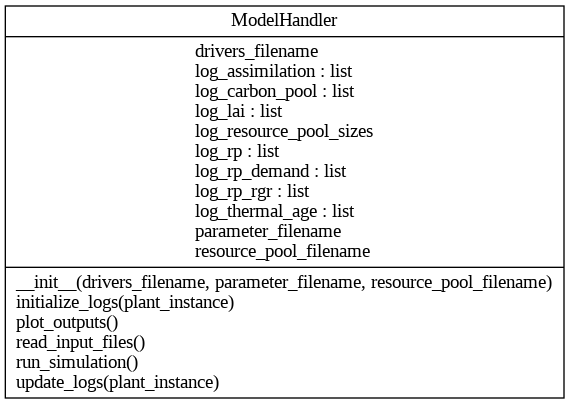

In [4]:
# run pyreverse with selected class (change the file name xxx.py)
# the -f ALL option will not filter out private attributes (private attributes filtered by default)

#!pyreverse -o png -p ExampleProject AG_environment.py
#!pyreverse -o png -p ExampleProject resource_pool.py
#!pyreverse -f ALL -o png -p ExampleProject plant.py
!pyreverse -f ALL -o png -p ExampleProject model_handler.py

# display the generated image
# all getter functions were removed to simplify diagram

from IPython.display import Image
Image('classes_ExampleProject.png')
